In [2]:
import sys
sys.path.append('../')

import torch as tc
import numpy as np
import matplotlib.pyplot as plt

import gpytorch

from rcgp.rcgp import TemporalRCGP
from rcgp.kernels import Matern32Kernel

from rcgp.weight_functions import IMQ, partial_y_IMQ

plt.rc('font', family='serif', size=20)
plt.rcParams['text.usetex'] = True

/opt/miniconda3/envs/RTGP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def generate_data(lengthscale=0.4, magnitude=2., var_y = 0.02):
    tc.manual_seed(42)  # For reproducibility

    x = tc.linspace(0, 1, 100)  # Same points for training and testing
    # Define known kernel parameters
    kernel = Matern32Kernel(lengthscale=tc.tensor(lengthscale), magnitude=tc.tensor(magnitude))

    cov_matrix = kernel.forward(x.reshape(-1,1), x.reshape(-1,1)) + 1e-5 * tc.eye(len(x))
    mean = tc.zeros(x.shape)

    true_f = tc.distributions.MultivariateNormal(mean, cov_matrix).sample()
    true_f = true_f - true_f.mean()

    noise = tc.distributions.Normal(0, var_y).sample(true_f.shape)

    y = true_f + noise

    return x, y, true_f


def add_outliers(y, late=False):
    tc.manual_seed(10)

    y_outliers = y.clone().detach()
    if late:
        outliers_loc = [85, 86, 88, 90, 91, 94, 98]
    else:
        outliers_loc = [1,2, 3, 6, 9, 10, 12]
    noise = np.abs(tc.distributions.Normal(loc=6, scale=1.).sample((len(outliers_loc), )))
    y_outliers[outliers_loc] = noise

    return y_outliers, outliers_loc



In [4]:
def run(ax, late):

    true_lengthscale, true_magnitude, true_var_y = (0.1, 2., 0.25)
    Xs, Ys, true_func = generate_data(lengthscale=true_lengthscale, magnitude=true_magnitude, var_y=true_var_y)
    Ys_outliers, outliers_loc = add_outliers(Ys, late=late)

    st_rcgp_robust = TemporalRCGP(ts=Xs.reshape(-1,1), Ys=Ys_outliers.reshape(-1,1), p=1)

    st_rcgp_robust.var_y = 0.04676114767789841
    st_rcgp_robust.temporal_lengthscale = 0.10464878380298615
    st_rcgp_robust.temporal_magnitude = 2.525326728820801

    with tc.no_grad():
        st_rcgp_robust.activate_robustness(func='m_pred') 
        st_rcgp_robust.adaptive_c() 

        (pred_st_rcgp_robust, std_st_rcgp_robust, _), _, _  = st_rcgp_robust.forward()
        pred_st_rcgp_robust = pred_st_rcgp_robust.squeeze()
        std_st_rcgp_robust = std_st_rcgp_robust.squeeze()

    #Data and True Function
    ax.plot(Xs.numpy(), Ys_outliers.numpy(), 'k.', label='Observed Data')

    #ST-RCGP
    ax.plot(Xs.numpy(), pred_st_rcgp_robust.squeeze().numpy(), color='green', label='ST-RCGP')
    ax.fill_between(Xs.numpy(), pred_st_rcgp_robust.squeeze().numpy() - 3 * std_st_rcgp_robust.squeeze().numpy(), pred_st_rcgp_robust.squeeze().numpy() + 3 * std_st_rcgp_robust.squeeze().numpy(), color='green', alpha=0.3, label='CI (ST-RCGP)')

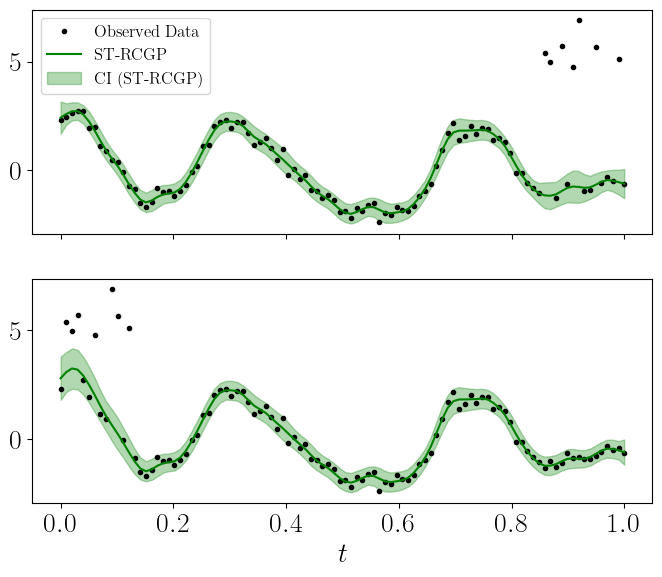

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6.4), sharex=True)  # Adjust figsize as needed

for ax, param in zip(axes, [True, False]):
    run(ax, param)

ax.set_xlabel(r"$t$")

axes[0].legend(fontsize=12)

plt.savefig("./results/strcgp-early-vs-late-outliers.pdf", format='pdf', bbox_inches='tight')